In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import pymorphy2
import itertools
import nltk
#nltk.download('stopwords')
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from gensim.test.utils import datapath
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from razdel import tokenize
from itertools import product
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report 
from sklearn.metrics import precision_recall_curve, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
news = pd.read_csv("articles.csv")
#print(news.shape)
#news.head(3)

In [3]:
users = pd.read_csv("users_articles.csv")
#users.head(3)

In [4]:
stopword_ru = stopwords.words('russian')
morph = pymorphy2.MorphAnalyzer()

In [5]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords

In [6]:
def clean_text(text):
    
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    return text

cache = {}

def lemmatization(text):

    if not isinstance(text, str):
        text = str(text)
    
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-':
            w = w[1:]
        if len(w)>1:
            if w in cache:
                words_lem.append(cache[w])
            else:
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru]
    
    return words_lem_without_stopwords

In [7]:
%%time
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

CPU times: total: 26.4 s
Wall time: 26.5 s


In [8]:
%%time
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: total: 3min 39s
Wall time: 3min 40s


In [9]:
texts = [t for t in news['title'].values]
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [10]:
%%time
N_topics = 15
N_words = 7
lda = LdaModel(common_corpus, num_topics=N_topics, id2word=common_dictionary)

CPU times: total: 35.4 s
Wall time: 34.5 s


In [11]:
temp_file = datapath("model.lda")
lda.save(temp_file)

lda = LdaModel.load(temp_file)

In [12]:
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]
unseen_doc = other_corpus[2]

In [13]:
x=lda.show_topics(num_topics=N_topics, num_words=N_words,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: год который сша это исследование новый россия
topic_1: космос двигатель атмосферный лесной эндрю норматив калининградский
topic_2: nn человек сотрудник пациент мужчина дело полиция
topic_3: фильм вирус мышь nn год картина выяснить
topic_4: офицер бизнесмен выяснить мозг вдвое миссия малое
topic_5: китай остров китайский японский япония океан достигать
topic_6: поверхность год планета место первый физика млн
topic_7: самолёт военный год россия российский путин nn
topic_8: рост год экономика доход увеличение миссия участок
topic_9: выяснить напомнить рейс километр вицепремьер аэропорт высота
topic_10: год это который россия мочь российский также
topic_11: отряд станция золото армения метро жуков вокзал
topic_12: год тыс город страна операция день который
topic_13: это год который человек мочь свой всё
topic_14: ребёнок год население пенсия товар налог погибнуть


In [14]:
def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [15]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
#topic_matrix.head(5)

In [16]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

### Добавляем функции расчета через медиану и максимальное значение:

In [17]:
def get_user_embedding_mean(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [18]:
def get_user_embedding_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [19]:
def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

### Расчитываем три массива с данными юзеров:

In [20]:
user_embeddings_mean = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_mean(x), 1)])
user_embeddings_mean.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_mean['uid'] = users['uid'].values
user_embeddings_mean = user_embeddings_mean[['uid']+['topic_{}'.format(i) for i in range(25)]]
#user_embeddings.head(3)

In [21]:
user_embeddings_median = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_median(x), 1)])
user_embeddings_median.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_median['uid'] = users['uid'].values
user_embeddings_median = user_embeddings_median[['uid']+['topic_{}'.format(i) for i in range(25)]]

In [22]:
user_embeddings_max = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x), 1)])
user_embeddings_max.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_max['uid'] = users['uid'].values
user_embeddings_max = user_embeddings_max[['uid']+['topic_{}'.format(i) for i in range(25)]]

In [23]:
target = pd.read_csv("users_churn.csv")
#target.sample(10)

### Создаем три датасета и поочередно прогоняем их по всем этапам работы модели:

In [24]:
X_mean = pd.merge(user_embeddings_mean, target, 'left')
#X.head(3)

In [25]:
X_median = pd.merge(user_embeddings_median, target, 'left')

In [26]:
X_max = pd.merge(user_embeddings_max, target, 'left')

### Mean:

In [27]:
dict_rez = {'Mean':[], 'Median':[], 'Max':[]} 

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_mean[['topic_{}'.format(i) for i in range(25)]], 
                                                    X_mean['churn'], random_state=0)

In [29]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [30]:
preds_mean = logreg.predict_proba(X_test)[:, 1]
#preds[:10]

In [31]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_mean)
fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)
RAS = roc_auc_score(y_test, preds_mean)
dict_rez['Mean'].append(thresholds[ix])
dict_rez['Mean'].append(fscore[ix])
dict_rez['Mean'].append(precision[ix])
dict_rez['Mean'].append(recall[ix])
dict_rez['Mean'].append(RAS)
#print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, Roc_Auc_Score=%.3f' % (thresholds[ix], 
                                                                                                #fscore[ix],
                                                                                            #precision[ix],
                                                                                                #recall[ix],
                                                                                                       #RAS))

### Median:

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_median[['topic_{}'.format(i) for i in range(25)]], 
                                                    X_median['churn'], random_state=0)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

preds_median = logreg.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds_median)
fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)
RAS = roc_auc_score(y_test, preds_median)
dict_rez['Median'].append(thresholds[ix])
dict_rez['Median'].append(fscore[ix])
dict_rez['Median'].append(precision[ix])
dict_rez['Median'].append(recall[ix])
dict_rez['Median'].append(RAS)

### Max:

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_max[['topic_{}'.format(i) for i in range(25)]], 
                                                    X_max['churn'], random_state=0)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

preds_max = logreg.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds_max)
fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)
RAS = roc_auc_score(y_test, preds_median)
dict_rez['Max'].append(thresholds[ix])
dict_rez['Max'].append(fscore[ix])
dict_rez['Max'].append(precision[ix])
dict_rez['Max'].append(recall[ix])
dict_rez['Max'].append(RAS)

### Выводим результаты:

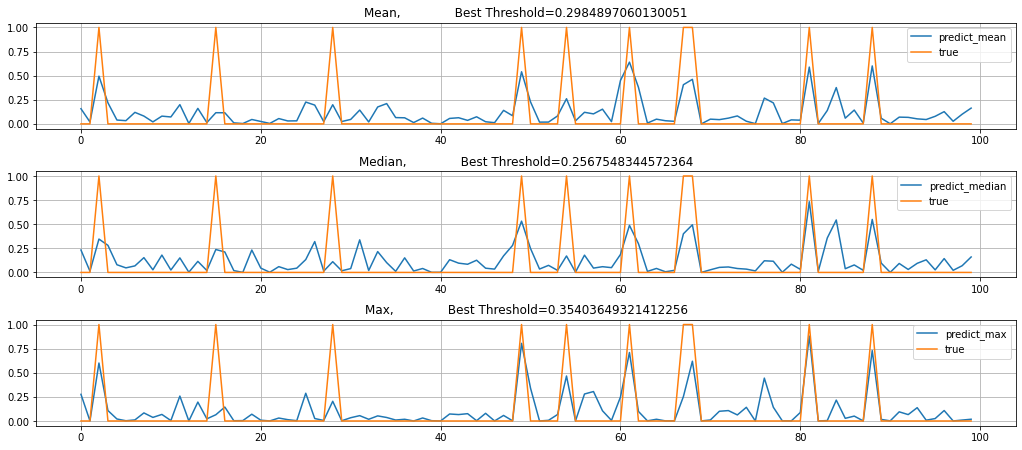

In [34]:
fig = plt.figure(figsize=(17,7))
plt.subplot (3, 1, 1)
plt.plot(preds_mean[:100],label = 'predict_mean' )
plt.plot(y_test.values[:100],label = 'true' )
plt.grid('On')
plt.title(f"Mean,              Best Threshold={dict_rez['Mean'][0]}")
plt.legend()
plt.subplot (3, 1, 2)
plt.plot(preds_median[:100],label = 'predict_median' )
plt.plot(y_test.values[:100],label = 'true' )
plt.grid('On')
plt.title(f"Median,              Best Threshold={dict_rez['Median'][0]}")
plt.legend()
plt.subplot (3, 1, 3)
plt.plot(preds_max[:100],label = 'predict_max' )
plt.plot(y_test.values[:100],label = 'true' )
plt.grid('On')
plt.title(f"Max,              Best Threshold={dict_rez['Max'][0]}")
plt.legend()

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

plt.show()

In [35]:
df_rez = pd.DataFrame(dict_rez, index=['Best Threshold','F-Score','Precision','Recall','Roc_Auc_Score'])
df_rez

,Mean,Median,Max
Best Threshold,0.298490,0.256755,0.354036
F-Score,0.718367,0.695811,0.696177
Precision,0.718367,0.628289,0.686508
Recall,0.718367,0.779592,0.706122
Roc_Auc_Score,0.959495,0.951127,0.951127


### Вывод:

#### По большинству показателей метод Mean находится в лидерах, однако по количеству найденных положительных ответов (recall) в лидерах метод Median. 

#### Метод Max отстает по всем параметрам, но порог принятия решений у него выше, чем у остальных методов. Также пики его графика заметно выше, чем у других методов. Все это, вероятно, связано с тем, что метод Max берет просто одно максимальное значение, никак не учитывая другие варианты, в отличие от Mean и Median.